In [1]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from PDE_FIND2 import *
from matplotlib.patches import Polygon
import os
import itertools
import statistics
import seaborn as sns
import pandas as pd

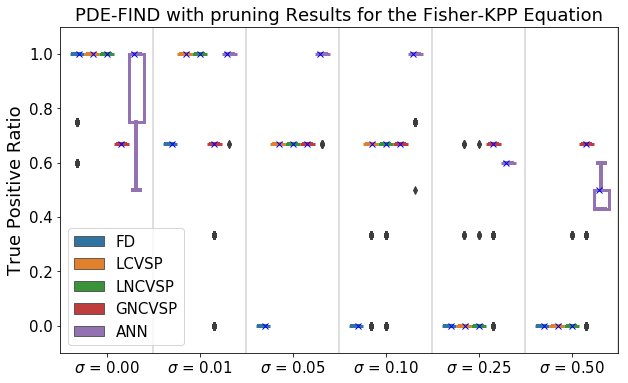

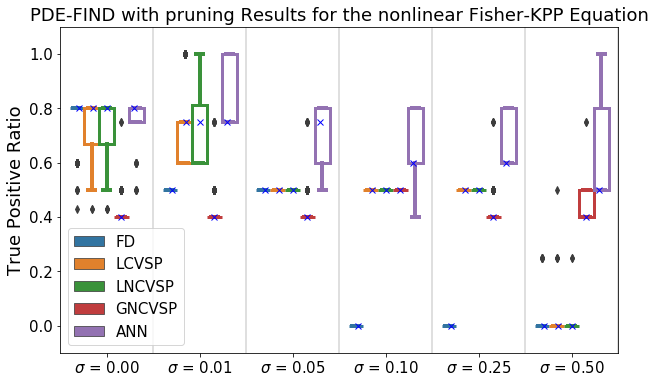

In [7]:
#where data was written
write_dir = 'pickle_data/'

#math model
#options are 'diffadv','fisher','fisher_nonlin'
model_str_list = ['diffadv','fisher','fisher_nonlin']

#noise levels that were considered
data_files_1 = ['00_','01_','05_','10_','25_','50_']

#other specs of implementation
algoName = 'Greedy'
shufMethod = 'bins'
deg = 2

#methods used for computation, as well as their abbreviations
methods = ['finite_differences','splines','NCV_bisplines',
           'global_NCV_bisplines_3','nn']
method_strings = ['FD','LCVSP','LNCVSP','GNCVSP','ANN']

for model_str in model_str_list:
    #load in true equation form
    if model_str == 'diffadv':
        deriv_list = ['u_{xx}','u_{x}']
    elif model_str == 'fisher':
        deriv_list = ['u_{xx}','u','u^2']
    elif model_str == 'fisher_nonlin':
        deriv_list = ['uu_{xx}','u_{x}^2','u','u^2']

    #initialize lists of the median TPR score
    median_TPR = []
    #vote for the equation form
    xi_vote = []
    #vote for each param individually
    xi_vote_params = []

    Make_df = True
    for d in data_files_1:   
        for j,m in enumerate(methods):

            #load in data
            if 'NCV_bisplines' not in m:
                filename = write_dir + algoName + '_' +d+m+ '_' + shufMethod + '_'+model_str+'_prune_tv_5050_1_21_deg_' +str(deg)+ '.npz'
            else:
                filename = write_dir + algoName + '_' +d+m+ '_' + shufMethod + '_'+model_str+'_prune_deg_' +str(deg)+ '.npz'

            if os.path.isfile(filename):

                #load in data
                data = np.load(filename)
                #compute median TPR without pruning
                median_TPR_no_prune = []
                #make list of TPR data without pruning
                for i in np.arange(len(data['xi_list_no_prune'].tolist())):    
                    median_TPR_no_prune.append(TP_TPFPFN(data['xi_list_no_prune'].tolist()[i],data['description'].tolist(),deriv_list))


                #create data frame of TPR, method, and noise level
                d_dict = {'TP':data['TP_score_list'].tolist(),'TPR_no_prune':median_TPR_no_prune
                          ,'method':method_strings[j],'sigma':d[:2]}
                df_new = pd.DataFrame(d_dict)
                #create initial data frame if not yet existing, otherwise just append
                if Make_df:
                    df = df_new
                    Make_df = False
                else:
                    df = df.append(df_new)

                #calculate median TPR (after pruning) from data frame
                median_TPR.append(statistics.median(data['TP_score_list'].tolist()))


                # now determine the most-common equation
                xi_vote_tmp = []
                for i in range(len(data['xi_list'])):
                    #convert nonzero entries of xi to a decimal number, signifying which equation
                    #form we are voting for
                    xi_vote_tmp.append(trans_rev((data['xi_list'][i] != 0)*1))
                #append the most common equation form
                xi_vote.append(most_common(xi_vote_tmp))

                matrix_vote_initialized = False
                #now generate parameter estimates from the most common equation form
                #by looping back through each xi value. If it matches the most commonly
                #chosen xi form, then we add its parameter estimates to the final list
                #
                # each column of A corresponds to one such xi estimate
                # each row of A corresponds to different terms in A
                for i in range(len(data['xi_list'])):
                    xi_full = data['xi_list'][i]
                    #if current xi matches most common xi
                    if xi_vote[-1]==trans_rev(xi_full != 0)*1:
                        if not matrix_vote_initialized:
                            A = xi_full
                            matrix_vote_initialized = True
                        else:
                            A = np.hstack((A,xi_full))
                #take mean along columns of A to get param estimates
                xi_vote_params.append(np.mean(A,axis=1))

            #if file does not exist, just make everything empty
            else:
                d_dict = {'TP':[],'method':m,'sigma':d[:2]}
                df_new = pd.DataFrame(d_dict)
                df.append(df_new)

                xi_vote.append([])
                xi_vote_params.append([])
                median_TPR.append(0)

        
    #make box and whisker plot for PDE-FIND with pruning

    #fontsize
    font = {'size': 15}
    mpl.rc('font', **font)

    #initialize figure
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.boxplot(
        x='sigma',
        y='TP',
        hue='method',
        data=df)


    plt.legend(loc='lower left')

    #trick to plot the median scores on top of box plots (depends on length of method)
    if len(methods) == 3:
        plot_diff = 0.27
        for i in np.arange(len(data_files_1)):
            if i == 0:
                median_xvec = np.array([-plot_diff,0,plot_diff])
            else:
                median_xvec = np.hstack([median_xvec,np.array([i-plot_diff,i,i+plot_diff])])
            plt.plot(i+[.5,.5],[-10,10],'k',linewidth=0.25)
        plt.plot(median_xvec,median_TPR,'bx')
    elif len(methods)==2:
        plot_diff = 0.2
        for i in np.arange(len(data_files_1)):
            if i == 0:
                median_xvec = np.array([-plot_diff,plot_diff])
            else:
                median_xvec = np.hstack([median_xvec,np.array([i-plot_diff,i+plot_diff])])
            plt.plot(i+[.5,.5],[-10,10],'k',linewidth=0.25)
        plt.plot(median_xvec,median_TPR,'bx')
    elif len(methods)==4:
        plot_diff = 0.28
        for i in np.arange(len(data_files_1)):
            if i == 0:
                median_xvec = np.array([-plot_diff,-plot_diff/2.0,plot_diff/2.0,plot_diff])
            else:
                median_xvec = np.hstack([median_xvec,np.array([i-plot_diff,i-plot_diff/2.0,i+plot_diff/2.0,i+plot_diff])])
            plt.plot(i+[.5,.5],[-10,10],'k',linewidth=0.25)
        plt.plot(median_xvec,median_TPR,'bx')
    elif len(methods)==5:
        plot_diff = 0.3
        for i in np.arange(len(data_files_1)):
            if i == 0:
                median_xvec = np.array([-plot_diff,-plot_diff/2.0,0,plot_diff/2.0,plot_diff])
            else:
                median_xvec = np.hstack([median_xvec,np.array([i-plot_diff,i-plot_diff/2.0,i,i+plot_diff/2.0,i+plot_diff])])
            plt.plot(i+[.5,.5],[-10,10],'k',linewidth=0.25)
        plt.plot(median_xvec,median_TPR,'bx')


    #loop through box plots and change line formatting and color
    for j in range(len(ax.artists)):

        #access box
        box = ax.artists[j]
        #box color
        col = box.get_facecolor()
        #set edge of box to be this color
        box.set_edgecolor(col)
        #set to white inside
        box.set_facecolor('white')
        #increase thickness
        box.set_linewidth(3)

        #update 6 lines of the box plot
        for k in np.arange(6):
            line = ax.lines[6*j+k]
            line.set_color(col)
            if k == 4:
                #get rid of median line
                line.set_linewidth(0)
            else:
                #increase thickness
                line.set_linewidth(4)

    #title
    if model_str == 'diffadv':
        title_str = "PDE-FIND with pruning Results for the Diffusion-Advection Equation"
    elif model_str == 'fisher':
        title_str = "PDE-FIND with pruning Results for the Fisher-KPP Equation"
    elif model_str == 'fisher_nonlin':
        title_str = "PDE-FIND with pruning Results for the nonlinear Fisher-KPP Equation"

    ax.set_title(title_str,fontsize=18)
    ax.set_ylabel("True Positive Ratio",fontsize=18)
    ax.set_xlabel("")
    plt.ylim((-1e-1,1+1e-1))

    ax.set_xticklabels(["$\sigma$ = 0.00","$\sigma$ = 0.01","$\sigma$ = 0.05",
                        "$\sigma$ = 0.10","$\sigma$ = 0.25","$\sigma$ = 0.50"])

    plt.savefig(algoName + '_'+model_str+'_prop_' + shufMethod + '_pruning.eps', format='eps', dpi=1000)

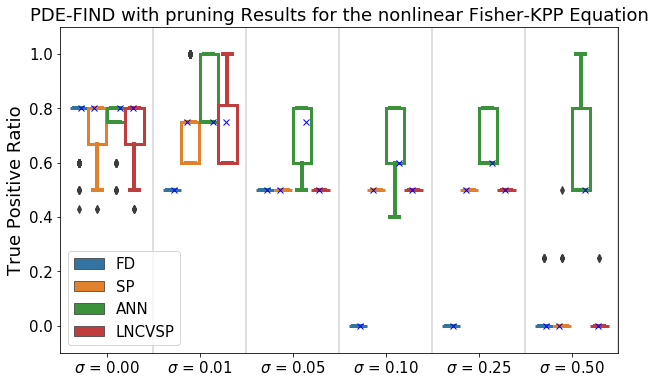

In [16]:
#make box and whisker plot for PDE-FIND with pruning

#fontsize
font = {'size': 15}
mpl.rc('font', **font)

#initialize figure
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(
    x='sigma',
    y='TP',
    hue='method',
    data=df)


plt.legend(loc='lower left')

#trick to plot the median scores on top of box plots (depends on length of method)
if len(methods) == 3:
    plot_diff = 0.27
    for i in np.arange(len(data_files_1)):
        if i == 0:
            median_xvec = np.array([-plot_diff,0,plot_diff])
        else:
            median_xvec = np.hstack([median_xvec,np.array([i-plot_diff,i,i+plot_diff])])
        plt.plot(i+[.5,.5],[-10,10],'k',linewidth=0.25)
    plt.plot(median_xvec,median_TPR,'bx')
elif len(methods)==2:
    plot_diff = 0.2
    for i in np.arange(len(data_files_1)):
        if i == 0:
            median_xvec = np.array([-plot_diff,plot_diff])
        else:
            median_xvec = np.hstack([median_xvec,np.array([i-plot_diff,i+plot_diff])])
        plt.plot(i+[.5,.5],[-10,10],'k',linewidth=0.25)
    plt.plot(median_xvec,median_TPR,'bx')
elif len(methods)==4:
    plot_diff = 0.28
    for i in np.arange(len(data_files_1)):
        if i == 0:
            median_xvec = np.array([-plot_diff,-plot_diff/2.0,plot_diff/2.0,plot_diff])
        else:
            median_xvec = np.hstack([median_xvec,np.array([i-plot_diff,i-plot_diff/2.0,i+plot_diff/2.0,i+plot_diff])])
        plt.plot(i+[.5,.5],[-10,10],'k',linewidth=0.25)
    plt.plot(median_xvec,median_TPR,'bx')


#loop through box plots and change line formatting and color
for j in range(len(ax.artists)):
    
    #access box
    box = ax.artists[j]
    #box color
    col = box.get_facecolor()
    #set edge of box to be this color
    box.set_edgecolor(col)
    #set to white inside
    box.set_facecolor('white')
    #increase thickness
    box.set_linewidth(3)
    
    #update 6 lines of the box plot
    for k in np.arange(6):
        line = ax.lines[6*j+k]
        line.set_color(col)
        if k == 4:
            #get rid of median line
            line.set_linewidth(0)
        else:
            #increase thickness
            line.set_linewidth(4)
            
#title
if model_str == 'diffadv':
    title_str = "PDE-FIND with pruning Results for the Diffusion-Advection Equation"
elif model_str == 'fisher':
    title_str = "PDE-FIND with pruning Results for the Fisher-KPP Equation"
elif model_str == 'fisher_nonlin':
    title_str = "PDE-FIND with pruning Results for the nonlinear Fisher-KPP Equation"
    
ax.set_title(title_str,fontsize=18)
ax.set_ylabel("True Positive Ratio",fontsize=18)
ax.set_xlabel("")
plt.ylim((-1e-1,1+1e-1))

ax.set_xticklabels(["$\sigma$ = 0.00","$\sigma$ = 0.01","$\sigma$ = 0.05",
                    "$\sigma$ = 0.10","$\sigma$ = 0.25","$\sigma$ = 0.50"])

plt.savefig(algoName + '_'+model_str+'_prop_' + shufMethod + '_pruning.eps', format='eps', dpi=1000)